In [2]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis


In [3]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4
from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap, BoundaryNorm

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy

#Trend
import xarrayMannKendall as XMK
import dask
from dask import delayed
import graphviz

## 1_Soil texture classification
note that the clay content values are in gram/kg and you neet to devide it with 10 to get percentage

In [4]:
clay = rxr.open_rasterio(f'DATA_r/4_Soil/SoilGrids_Clay1.tif').mean(dim='band')
sand=rxr.open_rasterio(f'DATA_r/4_Soil/SoilGrids_sand1.tif').mean(dim='band')
silt=rxr.open_rasterio(f'DATA_r/4_Soil/SoilGrids_silt1.tif').mean(dim='band')

SA_map=gpd.read_file('DATA_p/shapefile/south_asia_p.shp')

clay = clay.rio.clip(SA_map.geometry.apply(mapping), SA_map.crs, drop=True)
sand = sand.rio.clip(SA_map.geometry.apply(mapping), SA_map.crs, drop=True)
silt = silt.rio.clip(SA_map.geometry.apply(mapping), SA_map.crs, drop=True)


# Make consistent
clay=clay.sel(x=silt.x.values,y=silt.y.values,method='nearest')/10
sand=sand.sel(x=silt.x.values,y=silt.y.values,method='nearest')/10
silt=silt.sel(x=silt.x.values,y=silt.y.values,method='nearest')/10

silt

<xarray.DataArray (y: 1299, x: 1416)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 66.18 66.2 66.22 66.24 ... 97.7 97.72 97.74 97.76
  * y            (y) float64 37.07 37.05 37.02 37.0 ... 8.159 8.137 8.114 8.092
    spatial_ref  int32 0

In [5]:
# Make it consistent with an LIS grid (Not important)
#ds = xr.open_mfdataset(f'DATA_p/LIS/LIS_IMDc/LIS_IMDc_grid_All.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
def classify_soil(clay, sand, silt):
    # Sandy soils
    if sand > 85 and clay < 10 and silt <15:
        return 'Sand'
    elif 43 < sand < 85 and clay < 20 and silt < 50:
        return 'Sandy Loam'
    elif 45 < sand < 60 and 35 < clay < 55 and silt < 20:
        return 'Sandy Clay'
    
     # Loamy soils
    elif 70 < sand < 90 and clay < 15 and silt < 30:
        return 'Loamy Sand'
    elif 23 < sand < 52  and 7 < clay < 27  and  28 < silt <= 50 :
        return 'Loam'

    
    # Silty soils
    elif sand<20 and silt >= 80 and clay < 12:
        return 'Silt'
    elif sand<20 and 40<silt <= 73 and 27 < clay < 40:
        return 'Silty Clay Loam'
    elif sand < 20 and 40 < silt < 60 and 40 < clay < 60:
        return 'Silty Clay'
    elif sand <= 50 and 50 < silt < 88 and clay <= 27:
        return 'Silt Loam'
    
    # Clayey soils
    elif 20 < sand < 45  and 27 < clay <= 40 and 15 < silt <= 53:
        return 'Clay Loam'
    elif 45<sand<80 and 20 < clay <= 35 and silt < 28:
        return 'Sandy Clay Loam'
    elif sand <45 and clay > 40 and silt < 40:
        return 'Clay'
    else:
        return "other"
    


vectorized_classify = np.vectorize(classify_soil,otypes=[object])
soil_classification = vectorized_classify(clay,sand,silt)    

c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\numpy\lib\function_base.py:2412: RuntimeWarning: invalid value encountered in classify_soil (vectorized)
  outputs = ufunc(*inputs)


### Reclassify into HSG classes A,B,C,D based on runoff 

In [6]:
my_class = {
    'Sand': 1,    
    'Sandy Loam': 1,  
    'Loamy Sand':2,      
    'Loam': 2,  
    'Silt Loam': 3,  
    'Sandy Clay Loam':3,      
    'Clay Loam': 3,          
    'Silty Clay Loam': 3,       
    'Silt': 3,          
    'Sandy Clay': 4,
    'Clay': 4,
    'Silt Clay': 4,
    'other':np.nan
}


vectorized_map=np.vectorize(my_class.get)
hsg_class = vectorized_map(soil_classification)

#### Permeability class clasification

In [7]:
per_vector = {
    'Sand': 1,    
    'Sandy Loam': 2,  
    'Loamy Sand': 2,      
    'Loam': 3,  
    'Silt Loam': 3,  
    'Sandy Clay Loam':4,      
    'Clay Loam': 4,          
    'Silty Clay Loam': 5,   
    'Sandy Clay': 5,    
    'Silt': 6,          
    'Clay': 6,
    'Silt Clay': 6,
    'other':'other'
}


vectorized_map=np.vectorize(per_vector.get)
per_class = vectorized_map(soil_classification)

In [8]:
hsg_class = xr.DataArray(hsg_class,coords=[sand.y.values, sand.x.values], dims=["y", "x"], name="HSG_class")
txt_class = xr.DataArray(soil_classification,coords=[sand.y.values, sand.x.values], dims=["y", "x"], name="Texture_class")
per_class = xr.DataArray(per_class,coords=[sand.y.values, sand.x.values], dims=["y", "x"], name="per_class")

# Step 4: Create a Dataset 
dt = xr.Dataset({"HSG_class": hsg_class,
    "Texture_class": txt_class,
    "per_class": per_class
})

dt.to_netcdf('DATA_p/Physiography/1_texture_classes.nc')


: 

In [148]:
np.unique(hsg_class)
#np.unique(soil_classification)

#hsg_class

array([ 1.,  2.,  3.,  4., nan])

In [118]:
a = np.where(hsg_class == None, 'Unknown', hsg_class)
np.unique(a)

array(['C', 'Unknown'], dtype=object)

In [4]:
soil = xr.open_mfdataset(f'DATA_p/SOIL_DATA/Perm_Class_ind.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
soil_new=soil.sel(lat=soil.lat.values[::30],lon=soil.lon.values[::30])
ds=soil_new.Band1.compute()

In [6]:
ds

<xarray.DataArray 'Band1' (lat: 431, lon: 434)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 8.08 8.148 8.215 8.282 ... 36.85 36.92 36.98 37.05
  * lon      (lon) float64 68.19 68.25 68.32 68.39 ... 97.16 97.23 97.29 97.36
Attributes:
    long_name:           GDAL Band Number 1
    RepresentationType:  ATHEMATIC
    grid_mapping:        crs

## Gridwise

C:\Users\sstar\AppData\Local\Temp\ipykernel_14892\4019160623.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


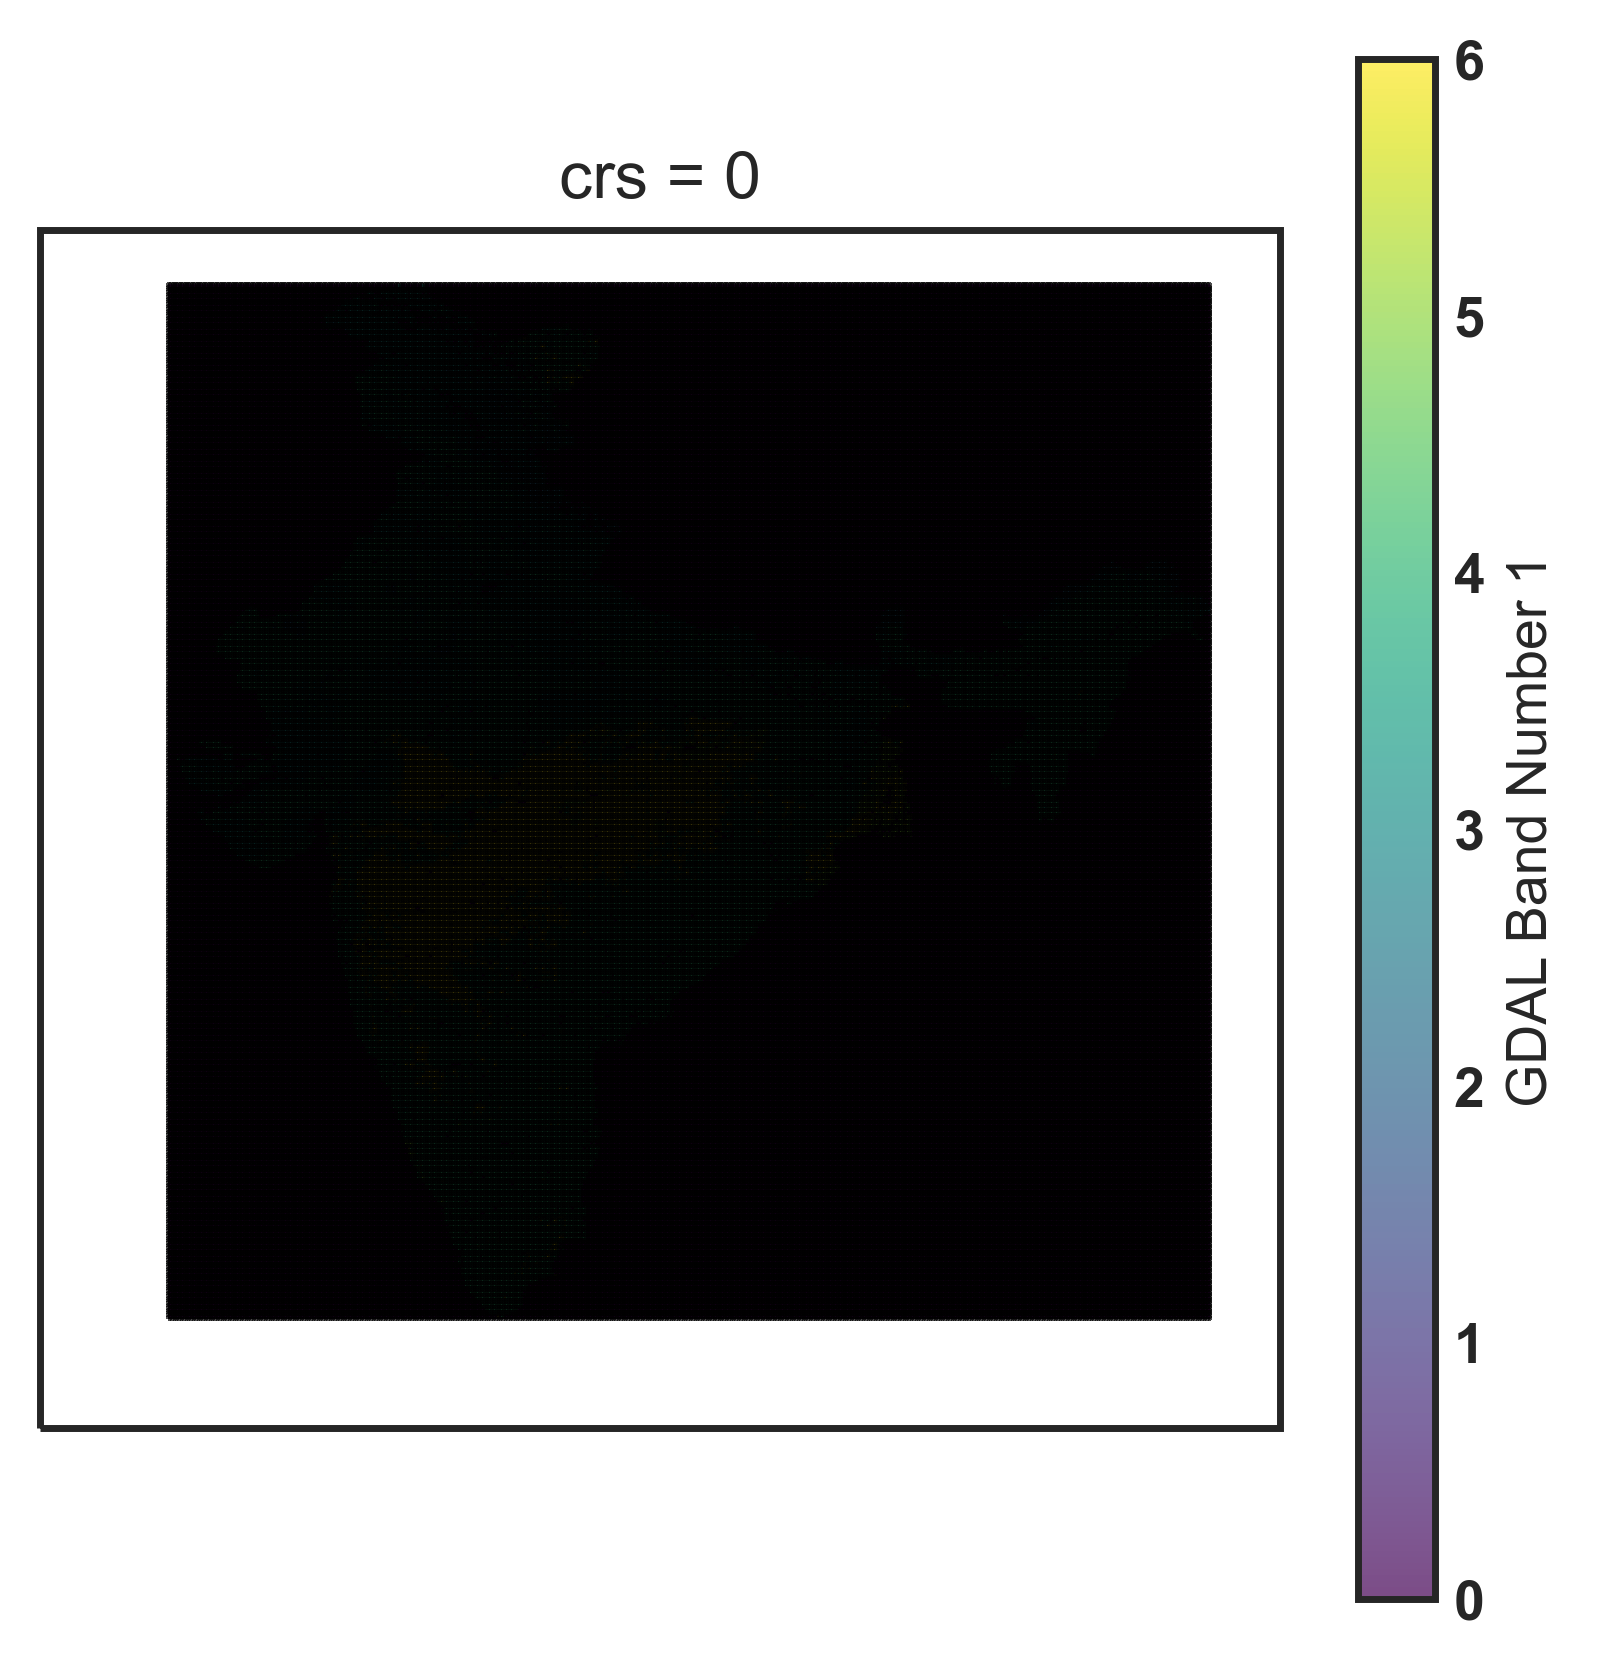

In [36]:
import scienceplots
from matplotlib.lines import Line2D
#plt.style.use(['science','no-latex','bright'])
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "Times New Roman"



basin_map = gpd.read_file('DATA_r/shapefiles_new/IndiShape/IndShape.shp')
riv_map = gpd.read_file('DATA_r/shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('DATA_r/shapefiles_new/india_admin/Country/India_country.shp')

num_colors = 50;marker_size = 6;marker_size2 = 5;alp = 0.1;alph = 0.05
basinEdge = 'black';basinEdge1 = 'blue';basinLine = 0.35

fig, ax = plt.subplots(1, 1, figsize=(5,5), subplot_kw={"projection": ccrs.PlateCarree()},
                         dpi=400, facecolor='white',constrained_layout=False)

ax.set_extent([64.571, 99.360,5, 38.599], ccrs.PlateCarree())
#basin_map.plot(ax=ax,color = 'none',edgecolor = basinEdge,linewidth=basinLine)
#ax.get_extent(ccrs.PlateCarree())

# Add gridlines
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.2, color='grey', alpha=0.2, linestyle='-')

#gl.xlabel_style = {"size" : 7,'family': 'Times New Roman','rotation': 0}
#gl.ylabel_style = {"size" : 7,'family': 'Times New Roman','rotation': 90}
#gl.top_labels = False
#gl.right_labels = False
#gl.xlocator = plt.MaxNLocator(5)  # Adjust the number of x-axis gridlines as needed
#gl.ylocator = plt.MaxNLocator(5)

# Define discrete intervals for permeability


ds.plot(ax=ax,cmap='viridis',edgecolor = basinEdge,linewidth=basinLine*1.2,alpha=0.7)
#ind_map.plot(ax=ax,color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
#riv_map.plot(ax=ax,color = 'white',alpha=0.4,linewidth=basinLine*0.5)

#ax.add_feature(cfeature.COASTLINE, edgecolor='black',facecolor='blue')
#ax.add_feature(cfeature.OCEAN,color='lightblue')


#Draw the colorbar
#cax = fig.add_axes([0.6, 0.18, 0.025, 0.14])   # left,bottom, widht, height


#cbar = plt.colorbar(main_plt, cax=cax, orientation='vertical')

#cbar.ax.yaxis.label.set_rotation(0)
#cbar.ax.yaxis.label.set_verticalalignment('top')
#cbar.ax.set_title('Permeability', fontsize=9, family='Times New Roman', weight='bold', pad=10)

# Manually set the ticks and labels
#cbar.set_ticks([bins[0], bins[-1]])
#cbar.set_ticklabels(['Low', 'High'],fontsize=7)


#plt.savefig("5_Physiographical Aspect/permeability.jpeg",dpi=1000)



### REgion wise

In [18]:
map=gpd.read_file('DATA_p/shapefile/south_asia_p.shp')
basin=map['Basin'].values

for i in range(len(map)):
    
    B=map[map['Basin']==map['Basin'][i]]
    
    ds.rio.set_spatial_dims(y_dim="lat",x_dim="lon", inplace=True)
    ds.rio.write_crs("EPSG:4326", inplace=True)
    ds_clip = ds.rio.clip(B.geometry.apply(mapping), B.crs, drop=True)
    
    map.loc[i,'permeability']=ds_clip.mean().values


C:\Users\sstar\AppData\Local\Temp\ipykernel_14892\4059660962.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


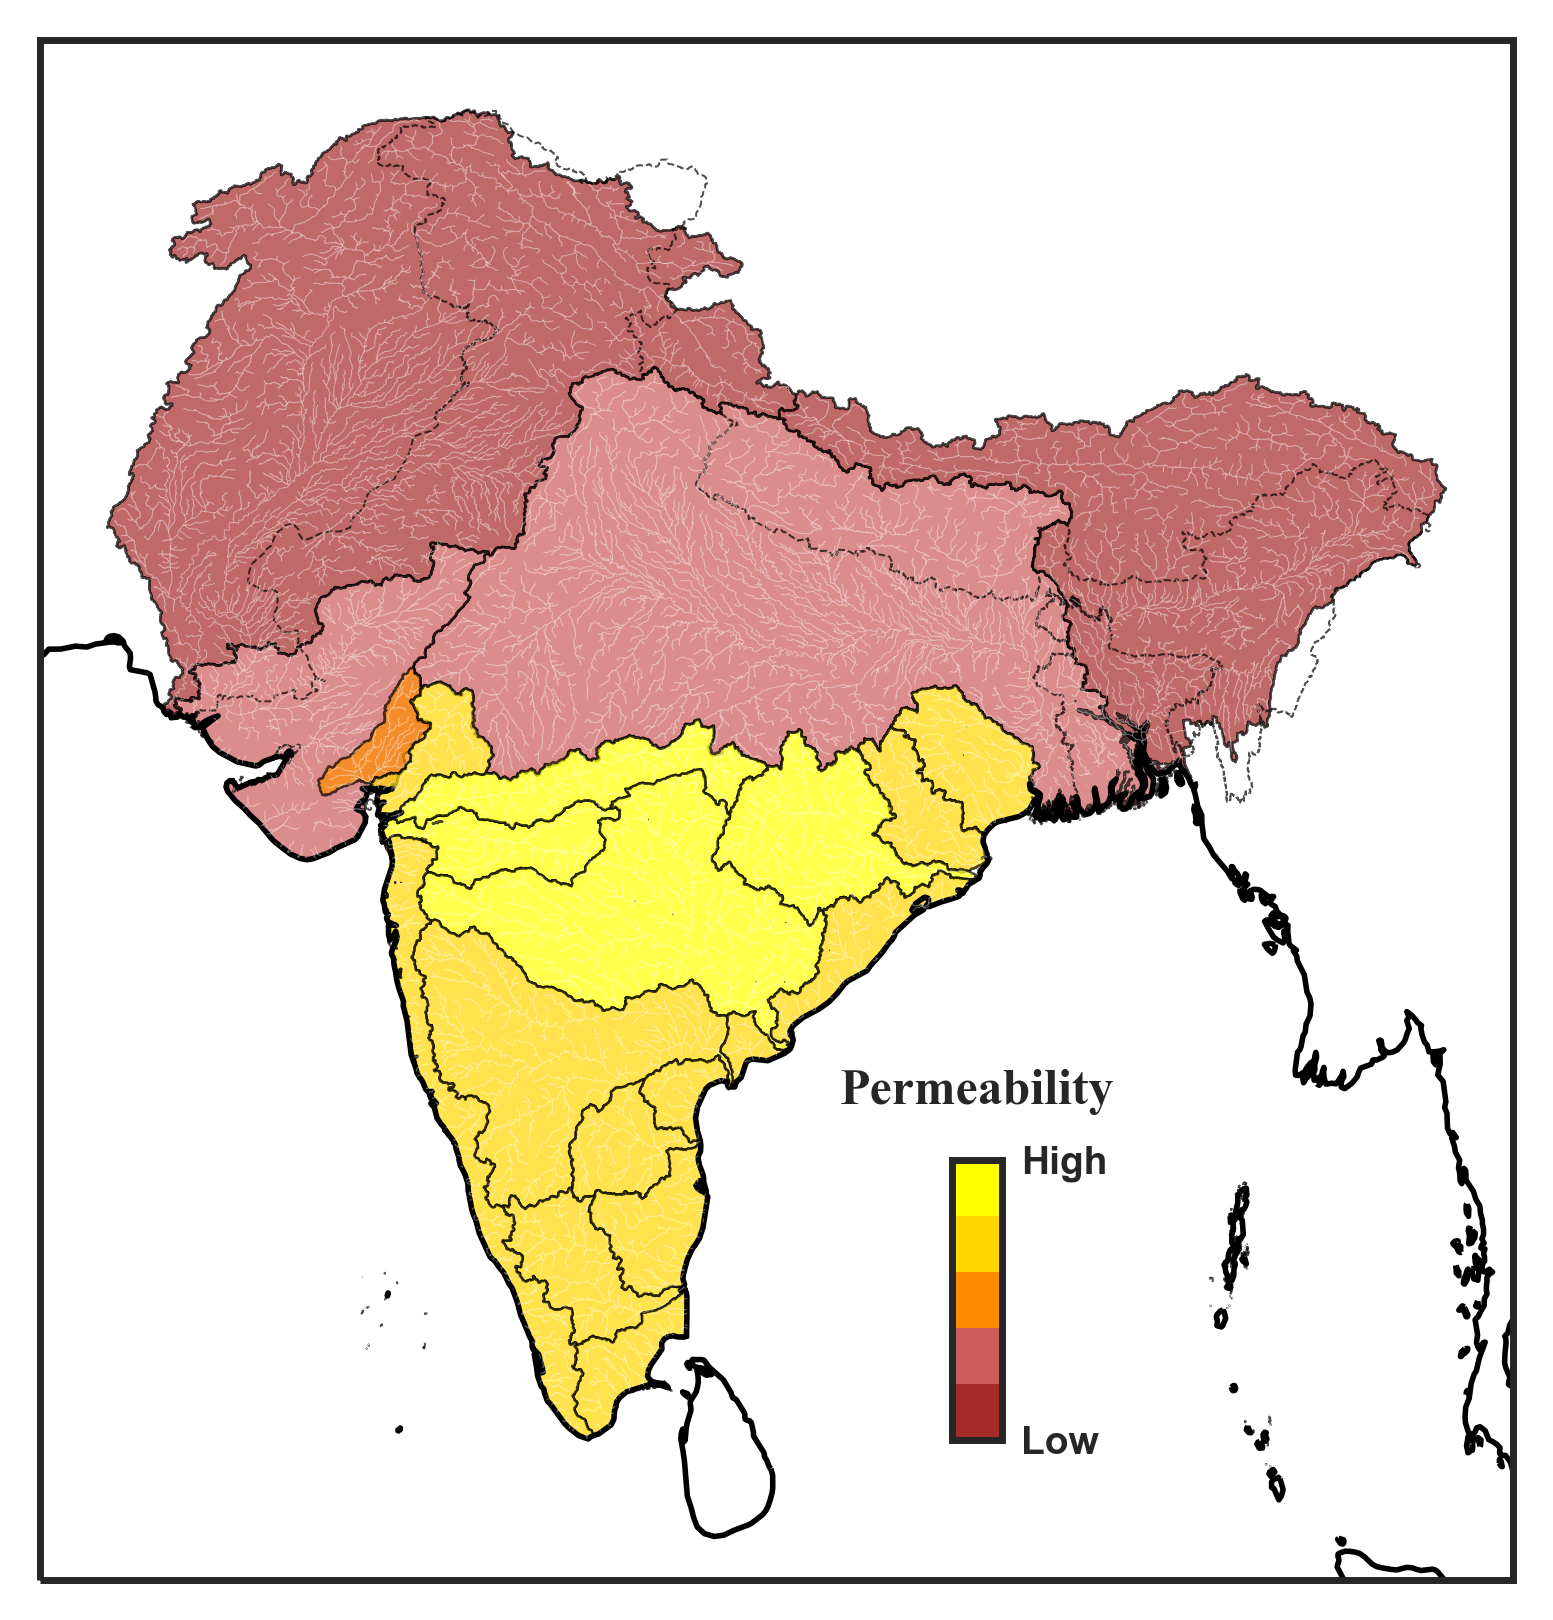

In [30]:
import scienceplots
from matplotlib.lines import Line2D
#plt.style.use(['science','no-latex','bright'])
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-white')


basin_map = gpd.read_file('DATA_r/shapefiles_new/IndiShape/IndShape.shp')
riv_map = gpd.read_file('DATA_r/shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('DATA_r/shapefiles_new/india_admin/Country/India_country.shp')

num_colors = 50;marker_size = 6;marker_size2 = 5;alp = 0.1;alph = 0.05
basinEdge = 'black';basinEdge1 = 'blue';basinLine = 0.35

fig, ax = plt.subplots(1, 1, figsize=(5,5), subplot_kw={"projection": ccrs.PlateCarree()},
                         dpi=400, facecolor='white',constrained_layout=False)

ax.set_extent([64.571, 99.360,5, 38.599], ccrs.PlateCarree())
#basin_map.plot(ax=ax,color = 'none',edgecolor = basinEdge,linewidth=basinLine)
#ax.get_extent(ccrs.PlateCarree())

# Add gridlines
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.2, color='grey', alpha=0.2, linestyle='-')

#gl.xlabel_style = {"size" : 7,'family': 'Times New Roman','rotation': 0}
#gl.ylabel_style = {"size" : 7,'family': 'Times New Roman','rotation': 90}
#gl.top_labels = False
#gl.right_labels = False
#gl.xlocator = plt.MaxNLocator(5)  # Adjust the number of x-axis gridlines as needed
#gl.ylocator = plt.MaxNLocator(5)

# Define discrete intervals for permeability
bins = np.linspace(map['permeability'].min(), map['permeability'].max(), num=6)  # Adjust number of bins as needed
cmap = ListedColormap(['brown','Indianred','darkorange','gold','yellow'])
norm = BoundaryNorm(bins, cmap.N)

main_plt=map.plot(column='permeability',ax=ax,cmap=cmap,edgecolor = basinEdge,linewidth=basinLine*1.2,alpha=0.7)
ind_map.plot(ax=ax,color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
riv_map.plot(ax=ax,color = 'white',alpha=0.4,linewidth=basinLine*0.5)

ax.add_feature(cfeature.COASTLINE, edgecolor='black',facecolor='blue')
#ax.add_feature(cfeature.OCEAN,color='lightblue')


#Draw the colorbar
cax = fig.add_axes([0.6, 0.18, 0.025, 0.14])   # left,bottom, widht, height

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the ScalarMappable, not used directly
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')

cbar.ax.yaxis.label.set_rotation(0)
cbar.ax.yaxis.label.set_verticalalignment('top')
cbar.ax.set_title('Permeability', fontsize=9, family='Times New Roman', weight='bold', pad=10)

# Manually set the ticks and labels
cbar.set_ticks([bins[0], bins[-1]])
cbar.set_ticklabels(['Low', 'High'],fontsize=7)


plt.savefig("5_Physiographical Aspect/permeability.jpeg",dpi=1000)



## MEan precipitation vs soil permeability correlation

In [49]:
mdl=5
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc","LIS_IMDcnew"]
lsm_M = xr.open_mfdataset(f'DATA_p/LIS/{model[mdl]}/{model[mdl]}_grid_All.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})


soil = xr.open_mfdataset(f'DATA_p/SOIL_DATA/Perm_Class_ind.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
soil_new=soil.interp(lat=lsm_M.lat.values,lon=lsm_M.lon.values)
ds=soil_new.Band1.compute()

C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\xarray\core\indexing.py:1436: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


TotalPrecip_tavg
lat      lon                        
5.55000  68.050003               NaN
         68.150002               NaN
         68.250000               NaN
         68.349998               NaN
         68.449997               NaN
...                              ...
37.44997 97.549553         19.212539
         97.649551         19.859300
         97.749550         20.493252
         97.849548         21.124093
         97.949547         21.751326

[96000 rows x 1 columns]

In [63]:
soil=ds.to_dataframe().reset_index(['lat','lon'])
rain=lsm_M.mean(dim='time')['TotalPrecip_tavg'].compute().to_dataframe().reset_index(['lat','lon'])
soil

,lat,lon,Band1
0,5.55000,68.050003,NaN
1,5.55000,68.150002,NaN
2,5.55000,68.250000,NaN
3,5.55000,68.349998,NaN
4,5.55000,68.449997,NaN
...,...,...,...
95995,37.44997,97.549553,NaN
95996,37.44997,97.649551,NaN
95997,37.44997,97.749550,NaN
95998,37.44997,97.849548,NaN


In [64]:
soil['rain']=rain['TotalPrecip_tavg']

In [65]:
A=soil.dropna(subset=['Band1'])
A1=A.dropna(subset=['rain'])

In [67]:
np.corrcoef(np.array(A1['Band1']),np.array(A1['rain']))

array([[1.        , 0.44543926],
       [0.44543926, 1.        ]])